In [1]:
%load_ext autoreload
%autoreload 2 

# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
spectra_file = 'GNPS-random-10k.mgf'

# spectra_file = "MASSBANK.mgf"  # Smaller set for faster runs

# How many spectra to sample for reference and query
n_spectra = 512 * 5

# limits for testing tolerance influence on performance
min_tolerance = 1e-4
max_tolerance = .30 # tolerance at >=.35 causes an OOM

# limits for testing num peaks influence on performance
min_num_peaks = 32
max_num_peaks = 2048

# limits for testing match_limit influence on performance
min_match_limit = 32
max_match_limit = 2048

# Max evals
num_evals = 15

# Default params
n_max_peaks = 1024

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA GeForce RTX 2070 with Max-Q Design (UUID: GPU-f6e241c8-f0ad-720e-be22-2713a6b0868d)
Number of CPU cores 12


In [2]:
from cudams.utils import argbatch, Timer, use_style
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
from cudams.utils import download
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from cudams.similarity import CudaCosineGreedy
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib

np.random.seed(42)
use_style()
assert cuda.is_available()

/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/sparsestack/StackedSparseArray.py:4: DeprecationWarning: `scipy.sparse.sputils.get_index_dtype` is deprecated along with the `scipy.sparse.sputils` namespace. `scipy.sparse.sputils.get_index_dtype` will be removed in SciPy 1.14.0, and the `scipy.sparse.sputils` namespace will be removed in SciPy 2.0.0.
  from scipy.sparse.sputils import get_index_dtype


## Default accuracy and performance

In [3]:
# import pickle
# spectra = pickle.loads(Path(download(spectra_file)).read_bytes())
# assert all(len(s.peaks) <= n_max_peaks for s in spectra), "All spectra must be shorter than n_max_peaks "
spectra = list(load_from_mgf(str(download(spectra_file))))
spectra[:5]

[Spectrum(precursor m/z=827.32, 10 fragments between 79.1 and 137.1),
 Spectrum(precursor m/z=555.42, 75 fragments between 51.9 and 555.4),
 Spectrum(precursor m/z=520.36, 88 fragments between 47.1 and 522.4),
 Spectrum(precursor m/z=890.48, 1 fragments between 302.1 and 302.1),
 Spectrum(precursor m/z=385.16, 49 fragments between 50.1 and 386.2)]

# Accuracy with recommended filters

In [4]:
from matchms.filtering import select_by_mz, select_by_relative_intensity, require_minimum_number_of_peaks
np.random.seed(42)

references = np.random.choice(
    spectra, 
    size=n_spectra,
)

queries = np.random.choice(
    spectra,
    size=n_spectra,
)

def process_spectrum(spectrum):
    """
    One of the many ways to preprocess the spectrum - we use this by default.
    """
    spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=n_max_peaks)
    spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
    return spectrum

references = list(process_spectrum(s) for s in references)
references = list(r for r in references if r is not None)

queries = list(process_spectrum(s) for s in queries)
queries = list(r for r in queries if r is not None)

references[:5], queries[:5]

([Spectrum(precursor m/z=306.21, 26 fragments between 58.0 and 326.2),
  Spectrum(precursor m/z=195.09, 60 fragments between 50.6 and 201.5),
  Spectrum(precursor m/z=261.03, 11 fragments between 94.0 and 199.0),
  Spectrum(precursor m/z=872.77, 27 fragments between 91.9 and 841.8),
  Spectrum(precursor m/z=269.05, 23 fragments between 72.1 and 269.0)],
 [Spectrum(precursor m/z=443.13, 109 fragments between 55.1 and 445.2),
  Spectrum(precursor m/z=340.28, 78 fragments between 55.0 and 341.3),
  Spectrum(precursor m/z=211.00, 10 fragments between 69.0 and 211.0),
  Spectrum(precursor m/z=720.42, 162 fragments between 70.1 and 759.4),
  Spectrum(precursor m/z=525.28, 248 fragments between 78.5 and 405.2)])

In [7]:
scores_cu = CudaCosineGreedy(
    n_max_peaks = n_max_peaks,
    batch_size = len(references)
).matrix(references, queries)

In [5]:
scores = CosineGreedy().matrix(references, queries)

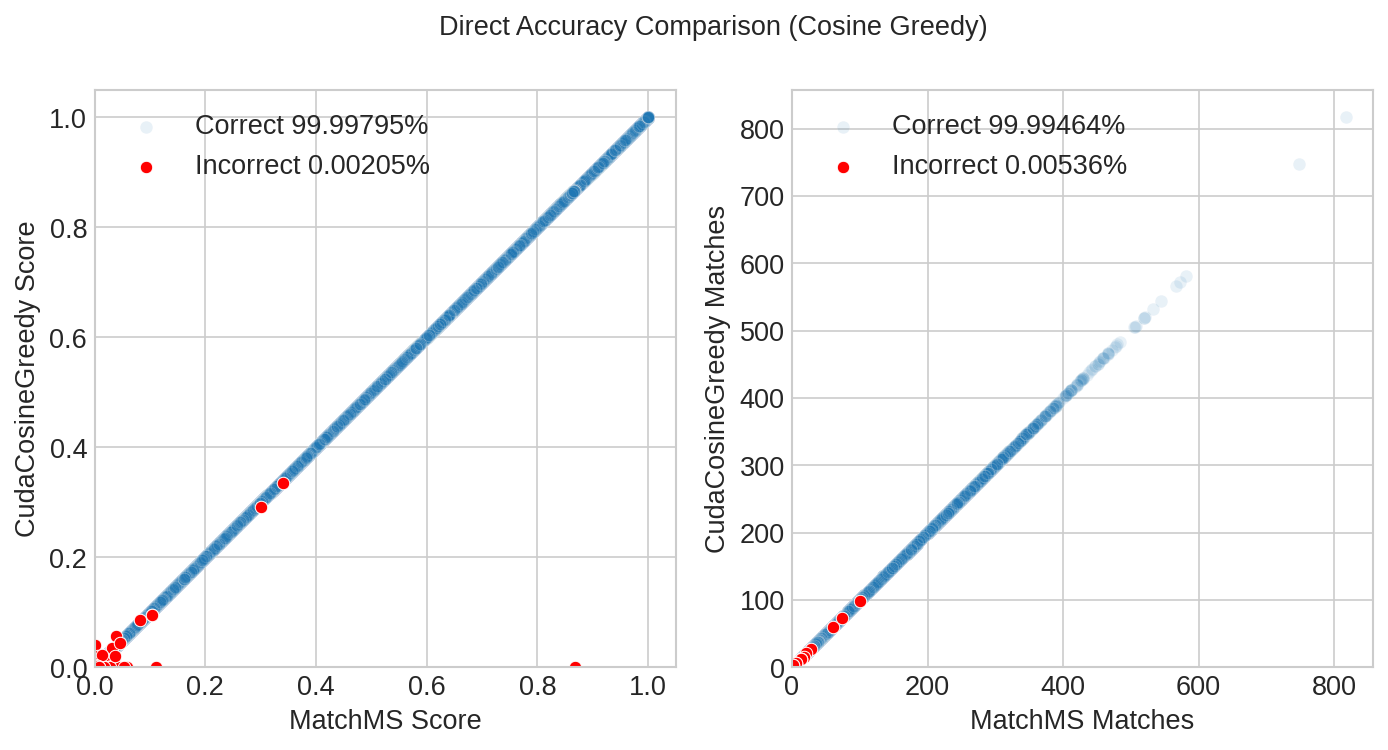

In [8]:
# Direct comparison of m
ax: plt.Axes

fig, axs = plt.subplots(1, 2, figsize=(11, 5), dpi=150)
ax = axs[0]
# fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

# fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)


cudams_scores = scores_cu['score'].ravel()
matchms_scores = scores['score'].ravel()

is_correct = np.isclose(cudams_scores, matchms_scores, atol=.001)
is_wong = ~is_correct
is_overflow = scores_cu['overflow'].ravel() == 1
is_wrong_without_warning = is_wong & ~is_overflow
is_wrong_with_warning = is_wong & is_overflow

sns.scatterplot(x=cudams_scores[is_correct], 
                y=matchms_scores[is_correct], 
                alpha=.1,
                label=f'Correct {is_correct.mean()*100:.5f}%',
                ax=ax)

sns.scatterplot(x=matchms_scores[is_wrong_with_warning],
                y=cudams_scores[is_wrong_with_warning], 
                c='orange', 
                label=f'Overflow {is_wrong_with_warning.mean()*100:.5f}%',
                ax=ax
            )

sns.scatterplot(x=matchms_scores[is_wrong_without_warning],
                y=cudams_scores[is_wrong_without_warning], 
                c='red', 
                label=f'Incorrect {(is_wrong_without_warning).mean()*100:.5f}%', 
                ax=ax)

ax.legend(loc='upper left')
ax.set_xlabel(f"MatchMS Score")
ax.set_ylabel(f"CudaCosineGreedy Score")
ax.set_ylim([0, None])
ax.set_xlim([0, None])

ax = axs[1]
cudams_matches = scores_cu['matches'].ravel()
matchms_matches = scores['matches'].ravel()

is_correct = np.isclose(cudams_matches, matchms_matches, atol=.001)
is_wong = ~is_correct
is_overflow = scores_cu['overflow'].ravel() == 1
is_wrong_without_warning = is_wong & ~is_overflow
is_wrong_with_warning = is_wong & is_overflow

sns.scatterplot(x=matchms_matches[is_correct], 
                y=cudams_matches[is_correct], 
                alpha=.1,
                label=f'Correct {is_correct.mean()*100:.5f}%',
                ax=ax)

sns.scatterplot(x=matchms_matches[is_wrong_with_warning],
                y=cudams_matches[is_wrong_with_warning], 
                c='orange', 
                label=f'Overflow {is_wrong_with_warning.mean()*100:.5f}%',
                ax=ax
            )

sns.scatterplot(x=matchms_matches[is_wrong_without_warning],
                y=cudams_matches[is_wrong_without_warning], 
                c='red', 
                label=f'Incorrect {(is_wrong_without_warning).mean()*100:.5f}%', 
                ax=ax)

ax.legend(loc='upper left')
ax.set_xlabel(f"MatchMS Matches")
ax.set_ylabel(f"CudaCosineGreedy Matches")
ax.set_ylim([0, None])
ax.set_xlim([0, None])

plt.suptitle("Direct Accuracy Comparison (Cosine Greedy)")
plt.savefig('assets/accuracy.png')
plt.show()

# Accuracy without any filters

In [11]:
np.random.seed(42)

references = np.random.choice(
    spectra, 
    size=n_spectra,
)

queries = np.random.choice(
    spectra,
    size=n_spectra,
)

def process_spectrum(spectrum):
    pass
    return spectrum

references = list(process_spectrum(s) for s in references)
references = list(r for r in references if r is not None)

queries = list(process_spectrum(s) for s in queries)
queries = list(r for r in queries if r is not None)

references[:5], queries[:5]

([Spectrum(precursor m/z=306.21, 254 fragments between 51.1 and 350.4),
  Spectrum(precursor m/z=195.09, 60 fragments between 50.6 and 201.5),
  Spectrum(precursor m/z=261.03, 11 fragments between 94.0 and 199.0),
  Spectrum(precursor m/z=872.77, 27 fragments between 91.9 and 841.8),
  Spectrum(precursor m/z=753.23, 1 fragments between 753.2 and 753.2)],
 [Spectrum(precursor m/z=557.20, 3 fragments between 340.1 and 561.3),
  Spectrum(precursor m/z=443.13, 475 fragments between 50.1 and 468.7),
  Spectrum(precursor m/z=340.28, 116 fragments between 55.0 and 341.3),
  Spectrum(precursor m/z=211.00, 10 fragments between 69.0 and 211.0),
  Spectrum(precursor m/z=720.42, 457 fragments between 70.1 and 1933.5)])

In [12]:
from cudams.similarity import CudaCosineGreedy
scores_cu = CudaCosineGreedy(
    n_max_peaks = n_max_peaks,
    batch_size = len(references),
).matrix(references, queries)
scores = CosineGreedy().matrix(references, queries)

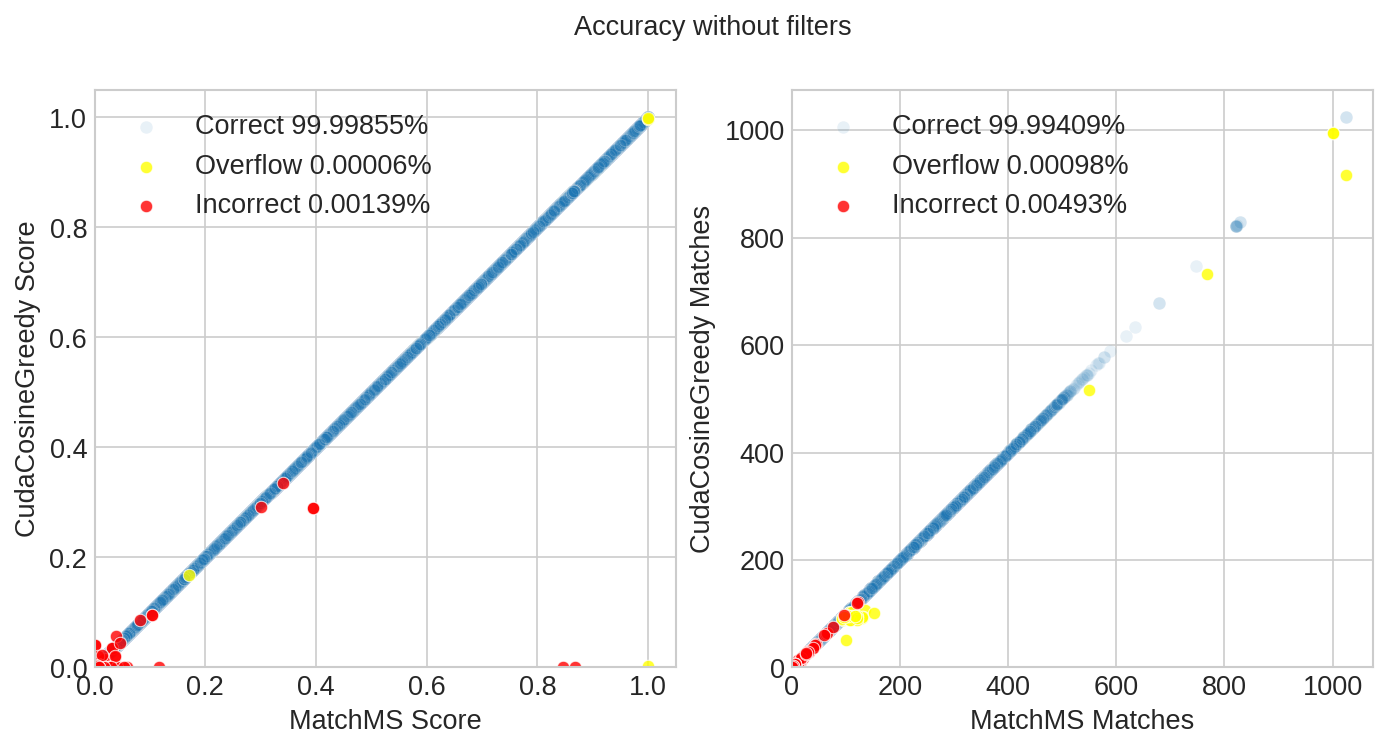

In [13]:

# Direct comparison of m
ax: plt.Axes

fig, axs = plt.subplots(1, 2, figsize=(11, 5), dpi=150)
ax = axs[0]
# fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
# fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)


cudams_scores = scores_cu['score'].ravel()
matchms_scores = scores['score'].ravel()

is_correct = np.isclose(cudams_scores, matchms_scores, atol=.001)
is_wong = ~is_correct
is_overflow = scores_cu['overflow'].ravel() == 1
is_wrong_without_warning = is_wong & ~is_overflow
is_wrong_with_warning = is_wong & is_overflow

sns.scatterplot(x=cudams_scores[is_correct], 
                y=matchms_scores[is_correct], 
                alpha=.1,
                label=f'Correct {is_correct.mean()*100:.5f}%',
                ax=ax)

sns.scatterplot(x=matchms_scores[is_wrong_with_warning],
                y=cudams_scores[is_wrong_with_warning], 
                c='yellow', 
                alpha=.8, label=f'Overflow {is_wrong_with_warning.mean()*100:.5f}%',
                ax=ax
            )

sns.scatterplot(x=matchms_scores[is_wrong_without_warning],
                y=cudams_scores[is_wrong_without_warning], 
                c='red', 
                alpha=.8, 
                label=f'Incorrect {(is_wrong_without_warning).mean()*100:.5f}%', 
                ax=ax)

ax.legend(loc='upper left')
ax.set_xlabel(f"MatchMS Score")
ax.set_ylabel(f"CudaCosineGreedy Score")
ax.set_ylim([0, None])
ax.set_xlim([0, None])

ax = axs[1]
cudams_matches = scores_cu['matches'].ravel()
matchms_matches = scores['matches'].ravel()

is_correct = np.isclose(cudams_matches, matchms_matches, atol=.001)
is_wong = ~is_correct
is_overflow = scores_cu['overflow'].ravel() == 1
is_wrong_without_warning = is_wong & ~is_overflow
is_wrong_with_warning = is_wong & is_overflow

sns.scatterplot(x=matchms_matches[is_correct], 
                y=cudams_matches[is_correct], 
                alpha=.1,
                label=f'Correct {is_correct.mean()*100:.5f}%',
                ax=ax)

sns.scatterplot(x=matchms_matches[is_wrong_with_warning],
                y=cudams_matches[is_wrong_with_warning], 
                c='yellow', 
                alpha=.8, label=f'Overflow {is_wrong_with_warning.mean()*100:.5f}%',
                ax=ax
            )

sns.scatterplot(x=matchms_matches[is_wrong_without_warning],
                y=cudams_matches[is_wrong_without_warning], 
                c='red', 
                alpha=.8, 
                label=f'Incorrect {(is_wrong_without_warning).mean()*100:.5f}%', 
                ax=ax)

ax.legend(loc='upper left')
ax.set_xlabel(f"MatchMS Matches")
ax.set_ylabel(f"CudaCosineGreedy Matches")
ax.set_ylim([0, None])
ax.set_xlim([0, None])

# plt.savefig('assets/matches_acc.jpg')
# plt.show()

# plt.savefig('assets/score_acc.jpg')
plt.suptitle("Accuracy without filters")
plt.savefig('assets/accuracy_no_filter.png')
plt.show()

## Tolerance vs performance

In [7]:
np.random.seed(123)

references = np.random.choice(
    spectra, 
    size=int(n_spectra**.5), 
    replace=False, # Just like BLINK, we randomly select without replacement.
)

queries = np.random.choice(
    spectra,
    size=int(n_spectra**.5),
    replace=False,
)

tolerances = np.logspace(
    np.log10(min_tolerance),
    np.log10(max_tolerance), 
    num=num_evals
)

jobs = []
for tolerance in tolerances:
    def loop(tolerance):
        tolerance = float(tolerance) # one of numba's many quirks
        kernel = CosineGreedy(
            tolerance=tolerance
        )
        scores = kernel.matrix(references, queries)
        
        kernel = CudaCosineGreedy(
            tolerance=tolerance,
            batch_size=batch_size,
            verbose=True,
        )
        scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu, kernel.kernel_time
    jobs.append(delayed(loop)(tolerance))
    
data = Parallel(4)(jobs)

100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


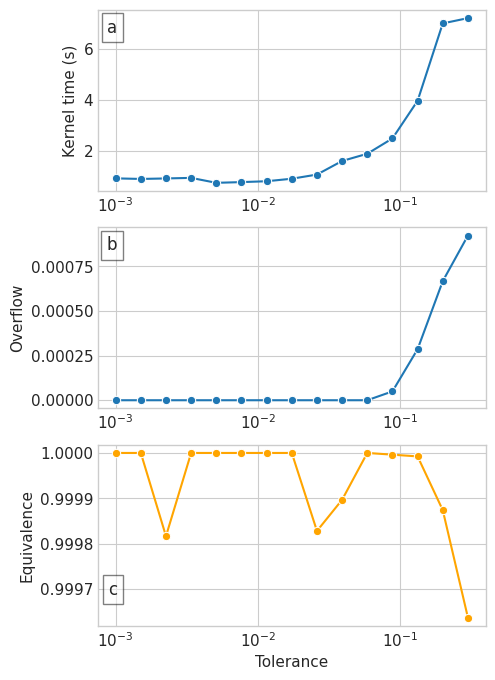

In [8]:
##### We use largest batch size for best error estimates
def plot_tol_and_perf(
    axis = None,
    data = data,
    tolerances=tolerances,
):
    ov_means = []
    match_means = []
    iseq_means = []
    kernel_times = []
    for tolerance, (scores, scores_cu, kernel_time) in zip(tolerances, data):
        a = scores['score'].ravel()
        am = scores['matches'].ravel()
        ov = scores_cu['overflow'].ravel() == 1
        b = scores_cu['score'].ravel()
        bm = scores_cu['matches'].ravel()
        iseq = np.isclose(a,b,atol=.001)
        
        ov_means.append(ov.mean())
        iseq_means.append(iseq.mean())
        match_means.append(bm.mean())
        kernel_times.append(kernel_time)
    
    # fig, axs = plt.subplot_mosaic(
    #     [['a'], ['b'], ['c']], 
    #     # layout='constrained',
    #     sharex=True,
    #     figsize=(6,6)
    # )
    
    ax = axis[0]
    sns.lineplot(x=tolerances, 
                 y=kernel_times,
                 marker='o',
                 ax=ax)
    ax.text(.05, 0.95, 'a', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    ax.set_ylabel("Kernel time (s)")
    ax.set_xscale('log')
    
    ax = axis[1]
    sns.lineplot(x=tolerances, 
                 y=ov_means,
                 marker='o',
                 ax=ax)
    
    ax.text(.05, 0.95, 'b', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    ax.set_ylabel("Overflow")
    ax.set_xscale('log')
    
    ax = axis[2]
    sns.lineplot(x=tolerances,
                 y=iseq_means, 
                 marker='o',
                 color='orange',
                 ax=ax)
    # thresh_idx = np.searchsorted(iseq_means, .999)
    ax.set_ylabel(r"Equivalence")
    ax.set_xscale('log')
    ax.set_xlabel("Tolerance")
    ax.text(.05, 0.25, 'c', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    

fig, axd = plt.subplot_mosaic(
    [['a'],['b'],['c']], 
    figsize=(5, 8)
)

plot_tol_and_perf(
    axis=[axd[k] for k in 'a b c'.split()], 
)

## Match limit vs performance

In [9]:
np.random.seed(111)

match_limits = np.logspace(
    np.log10(min_match_limit),
    np.log10(max_match_limit), 
    num=num_evals
)
references = np.random.choice(
    spectra, 
    size=int(n_spectra**.5), 
    replace=False, # Just like BLINK, we randomly select without replacement.
)

queries = np.random.choice(
    spectra,
    size=int(n_spectra**.5),
    replace=False,
)

jobs = []
for match_limit in match_limits:
    def loop(match_limit):
        match_limit = int(match_limit) # one of numba's many quirks
        kernel = CosineGreedy()
        scores = kernel.matrix(references, queries)
        kernel = CudaCosineGreedy(
            batch_size=batch_size,
            match_limit=match_limit,
            verbose=True,
        )
        scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu, kernel.kernel_time
    jobs.append(delayed(loop)(match_limit))
data = Parallel(4)(jobs)

100%|██████████| 1/1 [00:09<00:00,  9.92s/it]


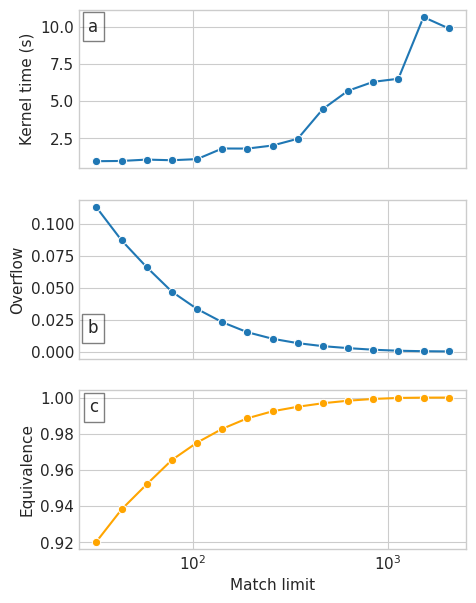

In [10]:
def plot_ml_and_perf(
    axis=None,
    match_limits=match_limits, 
    data=data
):
    ov_means = []
    match_means = []
    iseq_means = []
    kernel_times = []
    for match_limit, (scores, scores_cu, kernel_time) in zip(match_limits, data):
        a = scores['score'].ravel()
        am = scores['matches'].ravel()
        ov = scores_cu['overflow'].ravel() == 1
        b = scores_cu['score'].ravel()
        bm = scores_cu['matches'].ravel()
        iseq = np.isclose(a,b,atol=.001)
        
        ov_means.append(ov.mean())
        iseq_means.append(iseq.mean())
        match_means.append(bm.mean())
        kernel_times.append(kernel_time)
    
    
    ax = axis[0]
    sns.lineplot(x=match_limits, 
                 y=kernel_times,
                 marker='o',
                 ax=ax)
    ax.text(.05, 0.95, 'a', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    ax.set_ylabel("Kernel time (s)")
    
    ax = axis[1]
    sns.lineplot(x=match_limits, 
                 y=ov_means,
                 marker='o',
                 ax=ax)
    
    ax.text(.05, 0.25, 'b', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    ax.set_ylabel("Overflow")
    
    ax = axis[2]
    sns.lineplot(x=match_limits,
                 y=iseq_means, 
                 marker='o',
                 color='orange',
                 ax=ax)
    # thresh_idx = np.searchsorted(iseq_means, .999)
    ax.set_ylabel(r"Equivalence")

    ax.set_xscale('log')
    ax.set_xlabel("Match limit")
    ax.text(.05, 0.95, 'c', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    
fig, axd = plt.subplot_mosaic(
    [['a'],['b'],['c']], 
    figsize=(5, 7),
    sharex=True
)

plot_ml_and_perf(
    axis=[axd[k] for k in 'a b c'.split()], 
)

# Performance plots

Requires us to run notebooks under `notebooks/figures/performance` first.

MatchMS dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
Colab_T4 dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
RTX4090 dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
A100PCIE dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])


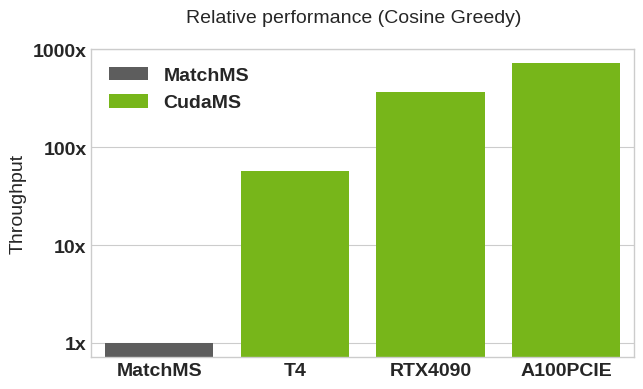

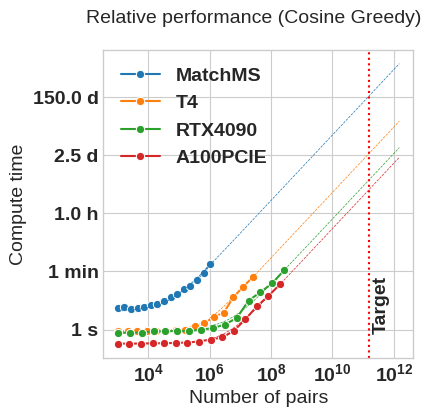

In [15]:
from sklearn.linear_model import LinearRegression
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import numpy as np

data = []
method_mapping = {'matchms': 'MatchMS', 'colab': 'T4', 
                  'rtx4090': 'RTX4090', 'a100pcie':'A100PCIE'}

for nb in sorted(Path('notebooks/figures/performance/').glob('*.ipynb')):
    method = nb.stem.split('_on_')[-1]
    nb_data = json.loads(nb.read_text())
    print(method, nb_data.keys())
    res = json.loads(' '.join(nb_data['cells'][-1]['outputs'][0]['text']))
    res['method'] = method
    res['pairs'] = res.get('pairs_cu', res.get('pairs'))
    res['times'] = res.get('times_cu', res.get('times'))

    res.pop('pairs_cu', None)
    res.pop('times_cu', None)

    for r in range(len(res['pairs'])):
        if 'cpu' in method:
            res['device'] = 'v32CPU'
        data.append({
            'pairs': res['pairs'][r],
            'times': res['times'][r],
            'device': res['device'],
            'nproc': res['nproc'],
            'method': method
        })

# Since experiments were done in different scales
# to save time,
df = pd.DataFrame(data)
pairs_scale = np.logspace(np.log2(df.pairs.min()), 
                          np.log2(df.pairs.max()),
                          base=2,
                          dtype='float64',
                          num=50)

def plot_perf(ax: plt.Axes, df: pd.DataFrame=df):
    perf_at_axvline = []
    for name in method_mapping:
        gr = df[df['method'].str.lower().str.contains(name)]
        if 'matchms' in name:
            full_range = np.logspace(np.log10(1000), np.log10(100_000 * 1_500_000 * 10), 50).reshape(-1, 1)
        else:
            full_range = np.logspace(np.log10(1_000_000), np.log10(100_000 * 1_500_000 * 10), 50).reshape(-1, 1)

        estimate_next = LinearRegression(positive=True)
        estimate_next.fit(np.array(gr[['pairs']]), np.array(gr[['times']]))
        estim_perf = estimate_next.predict(full_range)

        art = sns.lineplot(x=gr.pairs, 
                           y=gr.times, 
                           marker='o', label=method_mapping[name])

        sns.lineplot(x=full_range.ravel(), 
                     y=estim_perf.ravel(), 
                     linestyle='--',
                     linewidth=.5,
                     color=art.lines[-1].get_color())
        goal_num = 100_000 * 1_500_000
        perf_at_axvline.append([method_mapping[name],  goal_num / estimate_next.predict([[goal_num]]).item() ])
    ax.axvline(goal_num, 0, 1, color='red', linestyle=':', )
    ax.text(goal_num * 1.4, 1, f'Target', rotation=90)
    # ax.set_title(f'Wall-clock performance')
    ax.set_xlabel("Number of pairs")
    ax.set_ylabel("Compute time")
    ax.set_xscale('log')
    ax.set_yscale('log', base=60)
    def _formatter(v: float, p) -> str:
        # v is seconds, TODO: if less than hour, return units in seconds, then hours, and then days
        if v < 60:  # Less than a minute
            return f"{v:.0f} s"
        elif v < 3600:  # Less than an hour
            return f"{v / 60:.0f} min"
        elif v < 86400:  # Less than a day
            return f"{v / 3600:.1f} h"
        else:
            return f"{v / 86400:.1f} d"
    ax.yaxis.set_major_formatter(plt.FuncFormatter(_formatter))
    ax.grid(True, 'major', axis='y')

def plot_perf_at_goal(ax: plt.Axes, df: pd.DataFrame=df):
    perf_at_axvline = []
    gr_matchms = df[df['method'].str.lower().str.contains('matchms')]
    estimate_matchms = LinearRegression(positive=True)
    estimate_matchms.fit(np.array(gr_matchms[['pairs']]), np.array(gr_matchms[['times']]))
    goal_num = 100_000 * 1_500_000
    matchms_speed = (1 / estimate_matchms.predict([[goal_num]]).item())

    for name in method_mapping:
        gr = df[df['method'].str.lower().str.contains(name)]
        estimate = LinearRegression(positive=True)
        estimate.fit(np.array(gr[['pairs']]), np.array(gr[['times']]))
        goal_num = 100_000 * 1_500_000
        speed = (1 / estimate.predict([[goal_num]]).item())
        relative_speedup = speed / matchms_speed
        perf_at_axvline.append([method_mapping[name], relative_speedup])
    
    x, y = zip(*perf_at_axvline)
    hue = ['MatchMS', 'CudaMS', 'CudaMS', 'CudaMS']
    sns.barplot(x=x, y=y, ax=ax, hue=hue, palette=['#5d5d5d', '#7cd000'])
    # ax.set_title(f'Estimated relative throughput to MatchMS at Target')
    ax.set_ylabel("Throughput")
    # ax.set_xlabel("Method",)
    # ax.xaxis.set_tick_params(rotation=45)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter((lambda v,p: f'{int(v)}x'))
    
    ax.grid(True, 'major', axis='y')

from cudams.utils import use_style
use_style()
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
plot_perf_at_goal(ax)
plt.suptitle("Relative performance (Cosine Greedy)")
plt.savefig('assets/perf_speedup.svg')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_perf(ax)
plt.suptitle("Relative performance (Cosine Greedy)")
plt.savefig('assets/perf.svg')
plt.show()

NameError: name 'plot_heatmap' is not defined

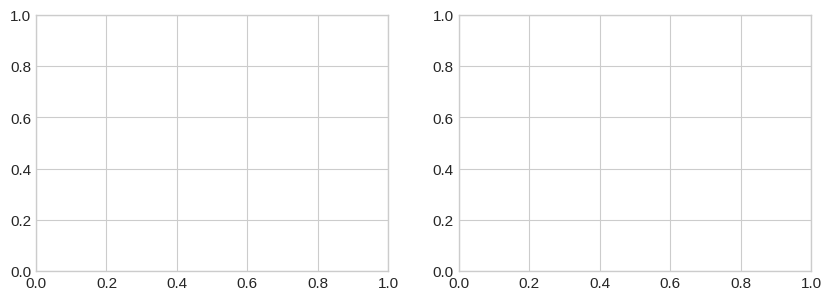

In [64]:
## Heatmap + Perf graph plot (analogue to fig 1 in BLINK)
fig, axd = plt.subplot_mosaic(
    [['a','b']], 
    figsize=(10,3.33)
)
plot_heatmap(axd['a'])
plot_perf(axd['b'])

# Scatter of error, analogue to fig 2 
fig, axd = plt.subplot_mosaic(
    [['a','b']],
    figsize=(10,3.33)
)
plot_scatter_diag([axd['a'], axd['b']])

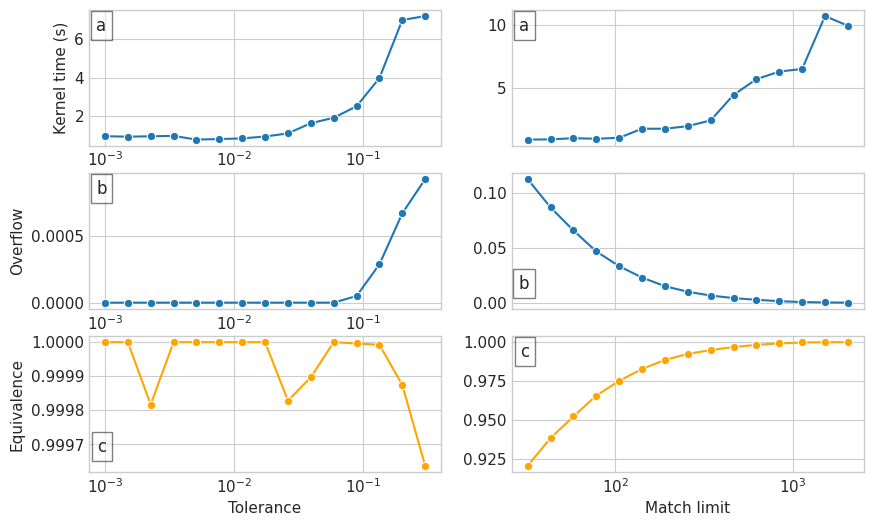

In [13]:
## Fig 3 equivalents, but two, one for tolerance, other for match limit
# Tolerance
fig, axd = plt.subplot_mosaic(
    [['a','A'],
     ['b','B'],
     ['c','C']], 
    figsize=(10,6),
)
plot_tol_and_perf(
    axis=[axd[k] for k in 'a b c'.split()], 
)

# match limit
plot_ml_and_perf(
    axis=[axd[k] for k in 'A B C'.split()], 
)
[axd[k].set_ylabel(None) for k in 'A B C'.split()];
[axd[k].set_xscale('log') for k in 'A B'.split()];
[axd[k].set_xticklabels([]) for k in 'A B'.split()];